In [160]:
# notebook settings
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.linalg import block_diag

# internal imports
from pympc.geometry.polyhedron import Polyhedron
from pympc.dynamics.discrete_time_systems import LinearSystem, AffineSystem, PieceWiseAffineSystem
from pympc.control.hybrid_benchmark.controllers import HybridModelPredictiveController
from pympc.control.hybrid_benchmark.utils import feasible_mode_sequences
from pympc.plot import plot_input_sequence, plot_state_trajectory

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [174]:
# numeric parameters
m = 1.
d = .5
r = .1
eps = .5
h = .02
x_max = np.array([d-r, 5.])
x_min = - x_max
u_max = np.array([5.])
u_min = - u_max
xu_max = np.concatenate((x_max, u_max))
xu_min = np.concatenate((x_min, u_min))

In [175]:
# state and input symbolic
q, v= sp.symbols('q v')
x = sp.Matrix([q, v])
f = sp.symbols('f')
u = sp.Matrix([f])
xu = x.col_join(u)

In [176]:
# mode 1: no contact
v_next = v + h*f/m
q_next = q + h*v
x_next = sp.Matrix([q_next, v_next])
S1 = LinearSystem.from_symbolic(x, u, x_next)
D1 = Polyhedron.from_bounds(xu_min, xu_max)
D1.add_symbolic_inequality(xu,sp.Matrix([q + v*h + - d + r,- q - v*h - d + r]))

In [177]:
# mode 2: contact with right wall
x_next = sp.Matrix([q, -eps*v])
S2 = AffineSystem.from_symbolic(x, u, x_next)
D2 = Polyhedron.from_bounds(xu_min, xu_max)
D2.add_symbolic_inequality(xu,sp.Matrix([- q - v*h + d - r]))

In [178]:
# mode 3: contact with left wall
x_next = sp.Matrix([q, -eps*v])
S3 = AffineSystem.from_symbolic(x, u, x_next)
D3 = Polyhedron.from_bounds(xu_min, xu_max)
D3.add_symbolic_inequality(xu,sp.Matrix([q + v*h + d - r]))

In [179]:
# piecewise affine system
S = PieceWiseAffineSystem([S1, S2, S3], [D1, D2, D3])
print 'Is well posed?', S.is_well_posed()

Is well posed? True


# Simulation

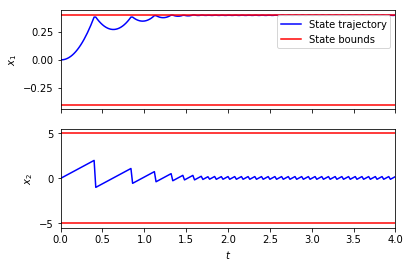

In [180]:
# push to the right wall with u=u_max
N_sim = 200
x0 = np.array([0., 0.])
x_sim, ms_sim = S.simulate(x0, [u_max]*N_sim)
plot_state_trajectory(x_sim, h, [x_min, x_max])

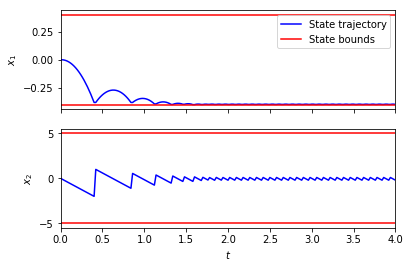

In [181]:
# push to the left wall with u=u_min
x_sim, ms_sim = S.simulate(x0, [u_min]*N_sim)
plot_state_trajectory(x_sim, h, [x_min, x_max])

# Solve MIQP with my branch and bound code

In [201]:
# controller parameters
N = 50
Q = np.eye(S.nx)
R = np.eye(S.nu)

# terminal set and cost
X_N = Polyhedron.from_bounds(*[np.zeros(S.nx)]*2)
P = np.zeros([S.nx]*2)

# hybrid MPC controller
method = 'CH'
norm = 'two'
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)

# initial conditions
x0 = np.array([0., 2.])

In [202]:
from pympc.control.hybrid_benchmark.branch_and_bound import branch_and_bound, best_first, breadth_first, depth_first
def solver(identifier, objective_cutoff):
    return controller.solve_relaxation(x0, identifier, objective_cutoff)
controller = HybridModelPredictiveController(S, N, Q, R, P, X_N, method, norm)
sol = branch_and_bound(
    solver,
    depth_first,
    controller.explore_in_chronological_order,
    tol=0.,
    tree_file_name='file_name'
)

|     Updates    |     Time (s)   |    Nodes (#)   |   Lower bound  |   Upper bound  |
 ---------------- ---------------- ---------------- ---------------- ----------------
  Root node        0.017            1                2.001            inf             
  New incumbent    0.566            54               2.001            224.738         
                   5.568            982              2.001            224.738         
  New incumbent    10.154           1791             2.001            171.415         
  New incumbent    10.792           1896             2.001            129.020         
  New incumbent    11.496           2004             2.001            93.839          
  New incumbent    12.226           2115             2.001            67.191          
  New incumbent    12.970           2229             2.001            57.722          
  Solution found   14.479           2488             57.722           57.722          

Explored 2488 nodes in 14.479 seconds: feas

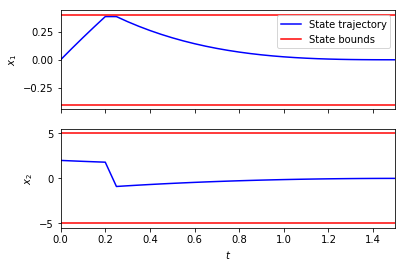

In [173]:
plot_state_trajectory(sol['state'], h, [x_min, x_max])

In [73]:
from pygraphviz import AGraph
from subprocess import call
from os import getcwd
graph = AGraph(directed=True, strict=True, filled=True)
graph.node_attr['style'] = 'filled'
graph.node_attr['fillcolor'] = 'white'
graph.add_node({'a':3})
graph.add_edge('a','c')

In [74]:
directory = getcwd() + '/' + 'file_name'
graph.write(directory + '.dot')
graph = AGraph(directory + '.dot')
graph.layout(prog='dot')
graph.draw(directory + '.pdf')

In [75]:
call(('open', directory + '.pdf'))

0

In [67]:
d = {'a':1, 'b':2}

In [68]:
str(d)

"{'a': 1, 'b': 2}"